In [1]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
import numpy as np

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from pyslabgrid import polygon as poly
from pyslabgrid import reckoner as reck
from pyslabgrid import mat as mat
from pyslabgrid import eqcat as eqc

In [2]:
# extract events on a profile/box
def get_boxpoints(x1,y1):
    x11,y11 = reck.reckon(x1,y1, 20, 220)
    xm, ym = [],[]
    for dd in range(0,450,5):
        tx,ty = reck.reckon(x11,y11, dd, 220+90)
        xm.append(tx)
        ym.append(ty)
    x2,y2 = reck.reckon(x1,y1, 40, 220)
    x3,y3 = reck.reckon(x2,y2, 500, 220+90)
    x4,y4 = reck.reckon(x3,y3, -40, 220)
    xs = [x1,x2,x3,x4,x1]
    ys = [y1,y2,y3,y4,y1]
    return xs, ys, xm, ym

In [3]:
catalogues = ['NZeqcat_Rollins13042020-subd-slab.csv',
             'Grue_NZeqcat_Rollins13042020SepiShallow_subd-slab.csv',
             'Grue_NZeqcat_Rollins13042020SepiDeep-subd.csv',]
folder ='classified_catalogs/'

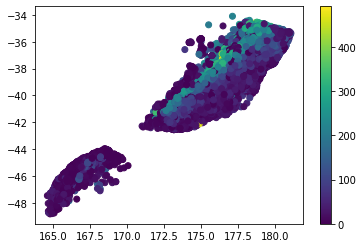

In [4]:
ecat = eqc.read_slabcatalogue(folder+catalogues[0])
lon, lat, dep, isslab = ecat['lon'], ecat['lat'], ecat['dep'], ecat['isslab']

plt.scatter(lon, lat, c=dep);
plt.colorbar();

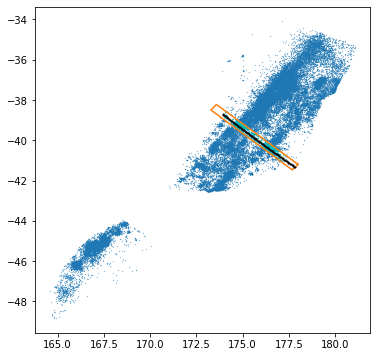

In [5]:

# 179.5, -39 # corner
# 177.5, -41.5
xs,ys,xm, ym = get_boxpoints(178, -41.2)

from matplotlib.path import Path
tupVerts = []
for x,y in zip(xs,ys):
    tupVerts.append((x,y))
p = Path(tupVerts) # make a polygon

points = np.vstack((lon,lat)).T 
IN = p.contains_points(points)
dep = np.array(dep)
isslab = np.array(isslab)
inpoints = points[IN]
kdep = dep[IN]
kisslab = isslab[IN]
klon = inpoints[:,0]
klat  = inpoints[:,1]

%matplotlib inline
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(lon, lat, 'o', markersize=0.2)
plt.plot(klon, klat, 'co', markersize=0.2)
plt.plot(xs,ys, '-');
plt.plot(xm,ym, 'ko', markersize=1);

In [6]:
slon, slat, sdep = [],[],[]
for x, y, z, is_slab \
         in zip(klon, klat, kdep, kisslab):
    if (is_slab==1) & (z<=500):
        slon.append(x)
        slat.append(y)
        sdep.append(z)

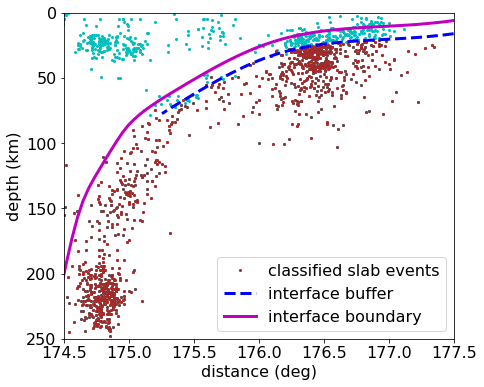

In [12]:
szone = 'hik'
if szone =='hik':
    dep_finterp = np.load('../01subduction-model/finterp/hik_finterp_lowerbounds.npy', allow_pickle=True)[()]
else:
    dep_finterp = np.load('../01subduction-model/finterp/puy_finterp_lowerbounds.npy', allow_pickle=True)[()]
lower_interface_depth = dep_finterp(np.transpose([xm, ym]))
kzm, kxm = [],[]
for d,x in zip(lower_interface_depth, xm):
    if d<=80:
        kzm.append(d)
        kxm.append(x)
hik_finterp = np.load('../01subduction-model/finterp/hik_finterp.npy', allow_pickle=True)[()]
puy_finterp = np.load('../01subduction-model/finterp/puy_finterp.npy', allow_pickle=True)[()]

if szone =='hik':
    dep_finterp = hik_finterp['depth']
else:
    dep_finterp = puy_finterp['depth']
    
iz = dep_finterp(np.transpose([xm,ym]))

%matplotlib inline
plt.rcParams.update({'font.size': 16})
#fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,10))
fig, ax = plt.subplots(figsize=(7,6))
ax.plot(klon, kdep,'o', color='c', markersize = 2);
ax.plot(slon, sdep,'o', color='brown', markersize = 2, label ='classified slab events');
ax.plot(kxm, kzm, 'b--', lw = 3, label = 'interface buffer')
ax.plot(xm, iz, 'm-', lw = 3, label ='interface boundary')
ax.set_ylim([0,250])
ax.set_xlim([174.5,177.5])
ax.legend()
ax.invert_yaxis()
ax.set_xlabel('distance (deg)')
ax.set_ylabel('depth (km)');
fig.savefig('clssification.png', dpi=300, facecolor='w')